In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GRU, Dense, SpatialDropout1D, Layer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.datasets import imdb
from sklearn.metrics import classification_report, accuracy_score

In [3]:
# Hyperparameters
max_words = 5000  # Maximum number of words to keep in the vocabulary
max_len = 200     # Maximum sequence length (number of words per review)
embedding_dim = 128  # Embedding layer output size

In [4]:
# Load the IMDB dataset (only the top 5000 words)
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=max_words)

# Pad sequences to ensure uniform input size
X_train_pad = pad_sequences(X_train, maxlen=max_len)
X_test_pad = pad_sequences(X_test, maxlen=max_len)

17464789/17464789 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [3]:
# Attention Layer (compatible with Keras)
class Attention(Layer):
    def __init__(self):
        super(Attention, self).__init__()

    def build(self, input_shape):
        self.W = self.add_weight(name="att_weight", shape=(input_shape[-1], 1),
                                 initializer="glorot_uniform", trainable=True)
        self.b = self.add_weight(name="att_bias", shape=(input_shape[1], 1),
                                 initializer="zeros", trainable=True)

    def call(self, x):
        e = tf.keras.backend.tanh(tf.keras.backend.dot(x, self.W) + self.b)
        a = tf.keras.backend.softmax(e, axis=1)
        output = x * a
        return tf.keras.backend.sum(output, axis=1)

In [5]:
# Define the GRU model
model = Sequential()

# Embedding layer
model.add(Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=max_len))

# Spatial dropout to prevent overfitting
model.add(SpatialDropout1D(0.2))

# GRU layer
model.add(GRU(units=128, dropout=0.2, recurrent_dropout=0.2))

# Output layer with a sigmoid activation for binary classification
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Model summary
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ spatial_dropout1d (SpatialDropout1D) │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru (GRU)                            │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [6]:
# Train the model
history = model.fit(X_train_pad, np.array(y_train), epochs=5, batch_size=64, validation_data=(X_test_pad, np.array(y_test)))

# Evaluate the model
loss, accuracy = model.evaluate(X_test_pad, np.array(y_test))
print(f"Test Accuracy: {accuracy * 100:.2f}%")

# Predicting the test set results
y_pred = (model.predict(X_test_pad) > 0.5).astype("int32")

# Classification report
print(classification_report(y_test, y_pred))

# Accuracy score
print(f"Accuracy: {accuracy_score(y_test, y_pred) * 100:.2f}%")

Epoch 1/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 323s 812ms/step - accuracy: 0.6131 - loss: 2376237568.0000 - val_accuracy: 0.6858 - val_loss: 0.5862
Epoch 2/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 328s 839ms/step - accuracy: 0.7273 - loss: 5524503.0000 - val_accuracy: 0.6765 - val_loss: 0.5886
Epoch 3/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 379s 831ms/step - accuracy: 0.7379 - loss: 0.5354 - val_accuracy: 0.6816 - val_loss: 0.5839
Epoch 4/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 380s 825ms/step - accuracy: 0.7550 - loss: 0.5109 - val_accuracy: 0.6834 - val_loss: 0.5827
Epoch 5/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 385s 831ms/step - accuracy: 0.7627 - loss: 0.4937 - val_accuracy: 0.6825 - val_loss: 0.5828
782/782 ━━━━━━━━━━━━━━━━━━━━ 51s 65ms/step - accuracy: 0.6851 - loss: 0.5862
Test Accuracy: 68.25%
782/782 ━━━━━━━━━━━━━━━━━━━━ 51s 64ms/step
              precision    recall  f1-score   support

           0       0.69      0.67      0.68     12500
           1       0.68      0.69      0.69     12500

    accuracy            

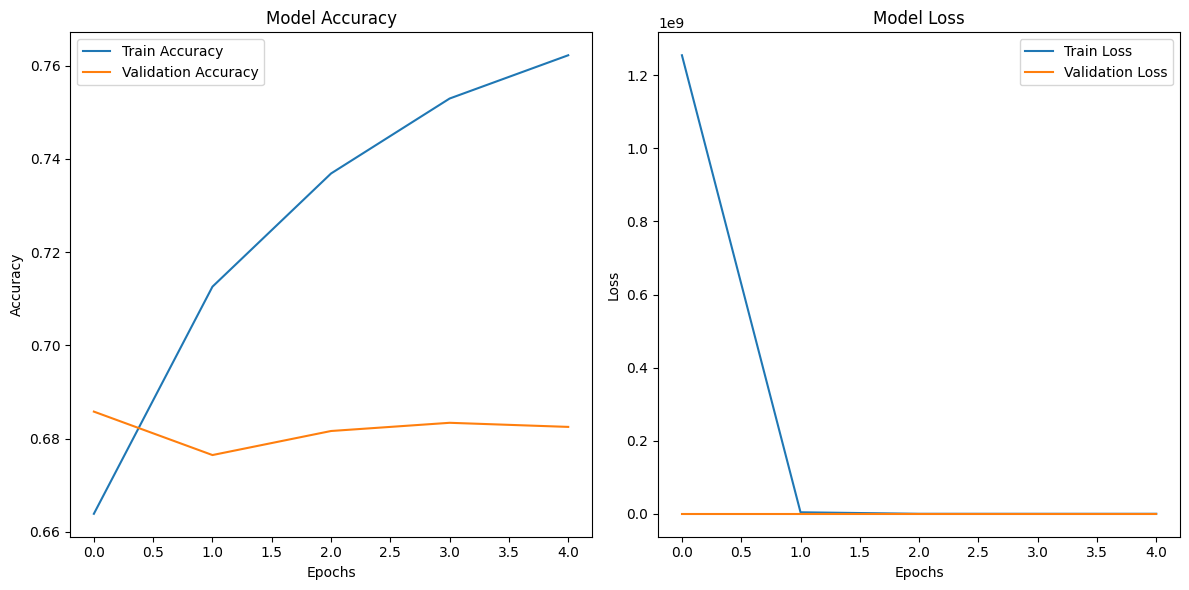

In [7]:
# Plotting accuracy and loss over epochs

# Plot Training & Validation Accuracy
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot Training & Validation Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [15]:
# Function to predict sentiment for a new review
def predict_sentiment(review):
    word_index = imdb.get_word_index()
    review = review.lower().split()
    review = [word_index.get(word, 0) for word in review]
    review = pad_sequences([review], maxlen=max_len)
    sentiment = model.predict(review)[0][0]
    return "Positive" if sentiment < 0.5 else "Negative"

In [18]:
# Example usage
example_reviews = [
    "This movie was fantastic! The acting was superb and the plot kept me engaged throughout.",
    "This is too bad",
    "This is too good",
    "The movie was fantastic! I really enjoyed the performances and the story was very engaging.",
    "This movie was terrible. The plot made no sense and the acting was just awful."
    ]
for example_review in example_reviews:
  print(f"Sentiment: {predict_sentiment(example_review)}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
Sentiment: Positive
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Sentiment: Negative
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Sentiment: Positive
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
Sentiment: Negative
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Sentiment: Negative


In [17]:
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Example reviews
example_reviews = [
    "The movie was fantastic! I really enjoyed the performances and the story was very engaging.",
    "This movie was terrible. The plot made no sense and the acting was just awful."
]

# Hyperparameters (same as in training)
max_words = 5000  # Must match the model's vocab size
max_len = 200     # Must match the model's input length

# Tokenize the example reviews (must use the same tokenizer setup as training)
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(example_reviews)  # Fit the tokenizer on the sample review

# Convert the reviews to sequences (word index vectors)
example_sequences = tokenizer.texts_to_sequences(example_reviews)

# Pad the sequences to ensure uniform input size
example_padded = pad_sequences(example_sequences, maxlen=max_len)

# Predict sentiment using the trained GRU model
predictions = model.predict(example_padded)

# Output predictions with sentiment label
for i, review in enumerate(example_reviews):
    print(f"Review: {review}")
    sentiment = "Positive" if predictions[i] > 0.5 else "Negative"
    print(f"Predicted Sentiment: {sentiment}\n")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
Review: The movie was fantastic! I really enjoyed the performances and the story was very engaging.
Predicted Sentiment: Positive

Review: This movie was terrible. The plot made no sense and the acting was just awful.
Predicted Sentiment: Positive

